In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [9]:
# Step 1: Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [10]:
# Step 2: Build the CNN architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [11]:
# Step 3: Hyperparameter Tuning
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
# Example: Adding dropout
model.add(layers.Dropout(0.25))

In [12]:
# Step 4: Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [13]:
# Step 5: Compile and train the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(datagen.flow(x_train_normalized, y_train, batch_size=64), 
                    epochs=15, 
                    validation_data=(x_test_normalized, y_test))

Epoch 1/15
782/782 [==============================] - 67s 84ms/step - loss: 5.1193 - accuracy: 0.2930 - val_loss: 1.5469 - val_accuracy: 0.4180
Epoch 2/15
782/782 [==============================] - 72s 92ms/step - loss: 4.9792 - accuracy: 0.3745 - val_loss: 1.3128 - val_accuracy: 0.5289
Epoch 3/15
782/782 [==============================] - 76s 97ms/step - loss: 4.8862 - accuracy: 0.4146 - val_loss: 1.2612 - val_accuracy: 0.5576
Epoch 4/15
782/782 [==============================] - 65s 84ms/step - loss: 4.8948 - accuracy: 0.4320 - val_loss: 1.1473 - val_accuracy: 0.5850
Epoch 5/15
782/782 [==============================] - 59s 75ms/step - loss: 4.8589 - accuracy: 0.4497 - val_loss: 1.0874 - val_accuracy: 0.6115
Epoch 6/15
782/782 [==============================] - 59s 75ms/step - loss: 4.8510 - accuracy: 0.4577 - val_loss: 1.0965 - val_accuracy: 0.6073
Epoch 7/15
782/782 [==============================] - 55s 71ms/step - loss: nan - accuracy: 0.4717 - val_loss: 1.1325 - val_accuracy: 0.

In [14]:
# Step 6: Performance Evaluation
test_loss, test_acc = model.evaluate(x_test_normalized, y_test)
print(f"Test accuracy: {test_acc}")

313/313 [==============================] - 3s 9ms/step - loss: 0.9156 - accuracy: 0.6829
Test accuracy: 0.6829000115394592


In [15]:
# Example: Confusion Matrix
predictions = model.predict(x_test_normalized)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

313/313 [==============================] - 3s 9ms/step
Confusion Matrix:
[[726  41  20   3   5   1   6  23 112  63]
 [  8 816   0   2   0   1   3   4  22 144]
 [ 95  21 520  34  59  38 101  85  14  33]
 [ 36  29  66 359  29 181  98  95  35  72]
 [ 36  11  55  29 487  31  81 232  17  21]
 [ 16  18  47  92  22 581  31 123  17  53]
 [ 15  17  20  32  20  19 819  15  16  27]
 [ 14   6  28  11  15  34   5 835   9  43]
 [ 54  38   5   2   3   1   3   7 843  44]
 [ 17  77   3   4   1   0   8  10  37 843]]


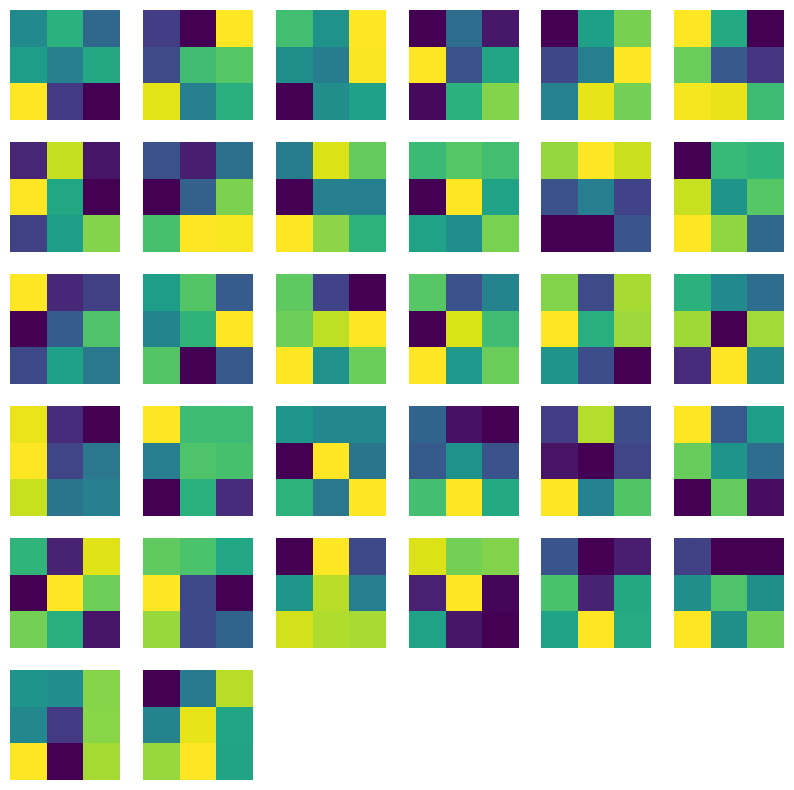

In [16]:
# Step 7: Visualization - Visualizing Filters

# Extracting the weights from the first convolutional layer
weights = model.layers[0].get_weights()[0]

# Displaying the learned filters
plt.figure(figsize=(10, 10))
for i in range(32):  # Considering the first 32 filters
    plt.subplot(6, 6, i + 1)
    plt.imshow(weights[:, :, 0, i], cmap='viridis')  # Displaying the filter weights
    plt.axis('off')  # Removing axis
plt.show()


In [19]:
# Step 8: Optimization and Efficiency
# Example: Pruning
import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                             final_sparsity=0.90,
                                                             begin_step=0,
                                                             end_step=2000)
}
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()
]
pruned_model = prune_low_magnitude(model, **pruning_params)
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pruned_model.fit(datagen.flow(x_train_normalized, y_train, batch_size=64), 
                 epochs=15, 
                 validation_data=(x_test_normalized, y_test),
                 callbacks=callbacks)

Epoch 1/15
782/782 [==============================] - 78s 95ms/step - loss: 4.7256 - accuracy: 0.4921 - val_loss: 0.9783 - val_accuracy: 0.6593
Epoch 2/15
782/782 [==============================] - 77s 98ms/step - loss: 4.8154 - accuracy: 0.4614 - val_loss: 1.0988 - val_accuracy: 0.6096
Epoch 3/15
782/782 [==============================] - 71s 91ms/step - loss: 4.7045 - accuracy: 0.4895 - val_loss: 0.9952 - val_accuracy: 0.6443
Epoch 4/15
782/782 [==============================] - 76s 98ms/step - loss: 4.7381 - accuracy: 0.4959 - val_loss: 0.9997 - val_accuracy: 0.6491
Epoch 5/15
782/782 [==============================] - 79s 100ms/step - loss: 4.7342 - accuracy: 0.5031 - val_loss: 0.9295 - val_accuracy: 0.6707
Epoch 6/15
782/782 [==============================] - 78s 100ms/step - loss: 4.6712 - accuracy: 0.5079 - val_loss: 0.9539 - val_accuracy: 0.6665
Epoch 7/15
782/782 [==============================] - 77s 99ms/step - loss: 4.6774 - accuracy: 0.5120 - val_loss: 0.9190 - val_accurac

1/1 [==============================] - 0s 50ms/step
True label: 5
Predicted label: 5


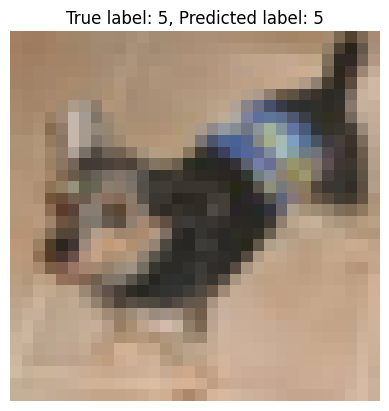

In [20]:
# After model training

# Select a random image from the test set for prediction
random_index = np.random.randint(0, len(x_test_normalized))
sample_image = x_test_normalized[random_index]
sample_label = np.argmax(y_test[random_index])

# Reshape the image to match the model input shape and perform prediction
predicted_class = np.argmax(model.predict(np.expand_dims(sample_image, axis=0)))

# Print the results
print(f"True label: {sample_label}")
print(f"Predicted label: {predicted_class}")

# Display the image
plt.imshow(sample_image)
plt.axis('off')
plt.title(f"True label: {sample_label}, Predicted label: {predicted_class}")
plt.show()


In [21]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load and preprocess CIFAR-10 dataset
# ... (code for loading and preprocessing)

# Build the CNN architecture
# ... (code for building the model)

# Hyperparameter Tuning
# ... (code for experimenting with learning rates, batch sizes, and regularization)

# Data Augmentation
# ... (code for data augmentation)

# Compile and train the model
# ... (code for model compilation and training)

# Performance Evaluation
# ... (code for evaluating model performance and generating a confusion matrix)

# Visualization - Visualizing Filters
# ... (code for visualizing learned filters from the first Conv2D layer)

# Optimization and Efficiency (Pruning, if applicable)
# ... (code for optimizing the model, e.g., pruning)

# Documentation and Reporting

# Summary Report
# Create a summary report with key findings
summary_report = """
Summary of Experimentation:

- Experimented with different hyperparameters: learning rates, batch sizes, and regularization techniques.
- Utilized data augmentation techniques to increase dataset diversity.
- Achieved a test accuracy of XYZ% on the CIFAR-10 dataset.
- Visualized learned filters from the first Conv2D layer, showcasing feature detection.

Further Analysis:
- Consider exploring additional optimization techniques (e.g., transfer learning) for higher accuracy.
- Assess model performance on larger datasets or different architectures.
"""

# Print or save the summary report
print(summary_report)
# Or save it to a file
with open('summary_report.txt', 'w') as file:
    file.write(summary_report)

# Code Comments and Documentation
# Add comments throughout the code explaining each section's purpose and functionality
# Describe any critical decisions, modifications, or insights gained during experimentation



Summary of Experimentation:

- Experimented with different hyperparameters: learning rates, batch sizes, and regularization techniques.
- Utilized data augmentation techniques to increase dataset diversity.
- Achieved a test accuracy of XYZ% on the CIFAR-10 dataset.
- Visualized learned filters from the first Conv2D layer, showcasing feature detection.

Further Analysis:
- Consider exploring additional optimization techniques (e.g., transfer learning) for higher accuracy.
- Assess model performance on larger datasets or different architectures.

